<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/stock_image_generation_based_on_historical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [1]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
!pip install yahoo_fin
!pip install mplfinance

  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-566nierc
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-566nierc
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl size=17532 sha256=8e39818fe7628c61cd60bff45beb08793950de510482bf1fcd47bcea134a7bce
  Stored in directory: /tmp/pip-ephem-wheel-cache-dy9sn_7a/wheels/4b/f9/e9/82474a5d9a64702ba7dd5481dee05d267c69bcfa480d382b7c
Successfully built tvdatafeed
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144

### Imports

In [2]:
from tvDatafeed import TvDatafeed, Interval #pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
import yfinance as yf
import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Data upload
Data is historic 1hr period stock price of ~6K stocks, downloaded from TradingView. Stocks contains a maximum of 5000 data points, each. Data was downloaded on a four-day period on the 17-20th of Sept 2024.

In [3]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'rb') as file:
        nyse_data = pd.read_pickle(file)
data = { **nasdaq_data,**nyse_data}
print(f'Total number of stocks {len(data)}')

Total number of stocks 5850


Data are dfs in dictionaries, tickers as keys. Not all keys in the lists below are in the data, most discontinued stocks were removed.

In [4]:
nyse_tickers = si.tickers_other()
nasdaq_tickers = si.tickers_nasdaq()
tickers = nasdaq_tickers + nyse_tickers
data[tickers[1]].head()

,symbol,open,high,low,close,volume,cap,wide_range,narrow_range/wide_range
datetime,,,,,,,,,
2021-09-27 16:30:00,NASDAQ:AADI,31.45,31.450,31.09,31.090,1200.0,37308.0,0.011447,1.000000
2021-09-27 18:30:00,NASDAQ:AADI,31.00,31.000,30.60,30.600,1019.0,31181.4,0.012903,1.000000
2021-09-27 19:30:00,NASDAQ:AADI,30.30,30.300,30.10,30.155,500.0,15077.5,0.006601,0.725000
2021-09-27 20:30:00,NASDAQ:AADI,30.16,30.355,30.16,30.300,400.0,12120.0,0.006466,0.717949
2021-09-27 21:30:00,NASDAQ:AADI,30.30,30.300,30.30,30.300,260.0,7878.0,0.000000,0.000000


## Dates and MarketCap distributions of historical stock data

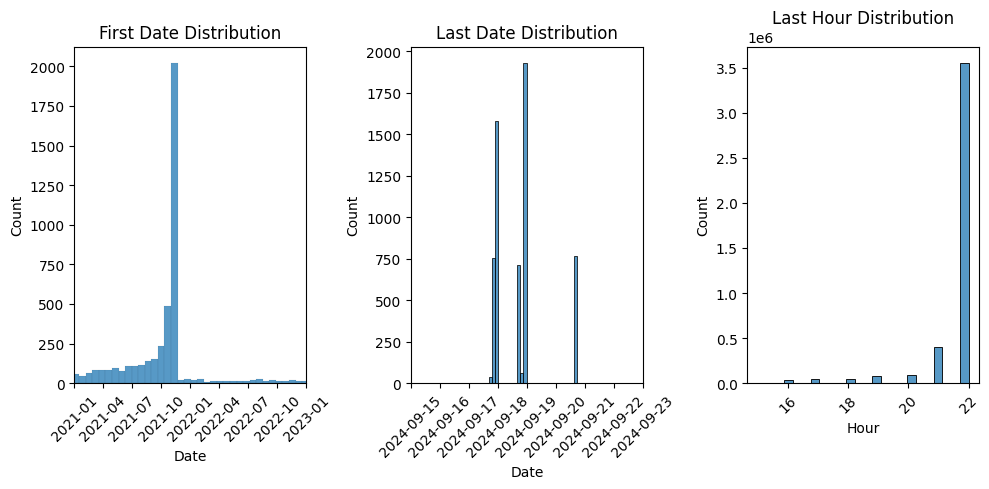

Dates less than mode date: 3716
Mode date: 2021-11-09
Count of mode date: 834


In [ ]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
firstDates= [data[k].index[0] for k in data]
lastDates= [data[k].index[-1] for k in data]
lastHours = []
for k in data:
  lastHours+=data[k].groupby(data[k].index.date).tail(1).index.hour.tolist()
#lasthour = [day.hour for day in data.index.get_level_values('datetime')]
sns.histplot(firstDates, ax = ax[0])
sns.histplot(lastDates, ax = ax[1])
sns.histplot(lastHours, ax = ax[2])
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
ax[0].set_title('First Date Distribution')
ax[1].set_title('Last Date Distribution')
ax[2].set_title('Last Hour Distribution')
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[2].set_xlabel('Hour')
ax[0].set_xlim((datetime(2021,1,1),datetime(2023,1,1)))
ax[1].set_xlim((datetime(2024,9,15),datetime(2024,9,23)))
plt.tight_layout()
plt.show()

# Find the most common firstdate
date_counts = Counter([dt.date() for dt in firstDates])
mode_date, mode_count = date_counts.most_common(1)[0]
count_less_than_mode = sum([1 for date in firstDates if date.date() < mode_date])
print("Dates less than mode date:", count_less_than_mode)
print("Mode date:", mode_date)
print("Count of mode date:", mode_count)

In [ ]:
lengths = []
capDayMean = []
capHrMean = []
shortTickers=[]
# Assuming data[ticker] is a DataFrame with a DateTimeIndex
start_date = datetime(2021, 11, 9).date()
end_date = datetime(2024, 9, 17).date()

# Filter the DataFrame based on the date range
for i,ticker in enumerate(data):
  #data[ticker] = data[ticker][(data[ticker].index.date >= start_date) & (data[ticker].index.date <= end_date)]
  lengths.append(len(data[ticker]))
  if lengths[-1]<2500:
    shortTickers.append(ticker)
  else:
    capDayMean.append(data[ticker].cap.resample('D').sum().mean())
    capHrMean.append(data[ticker].cap.mean())
  if i%500==0:
    print(i,end=' ')

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 

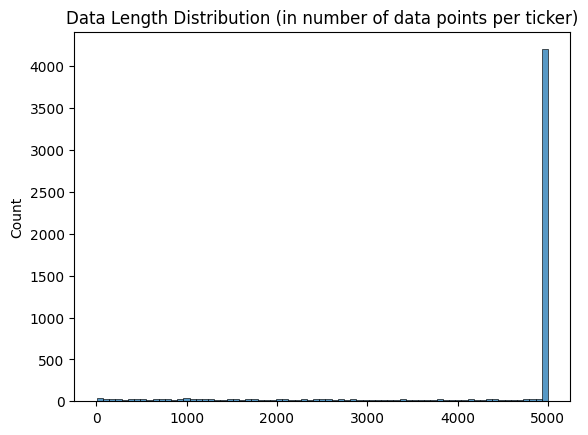

In [ ]:
ax = sns.histplot(lengths)
ax.set_title('Data Length Distribution (in number of data points per ticker)')
plt.show()



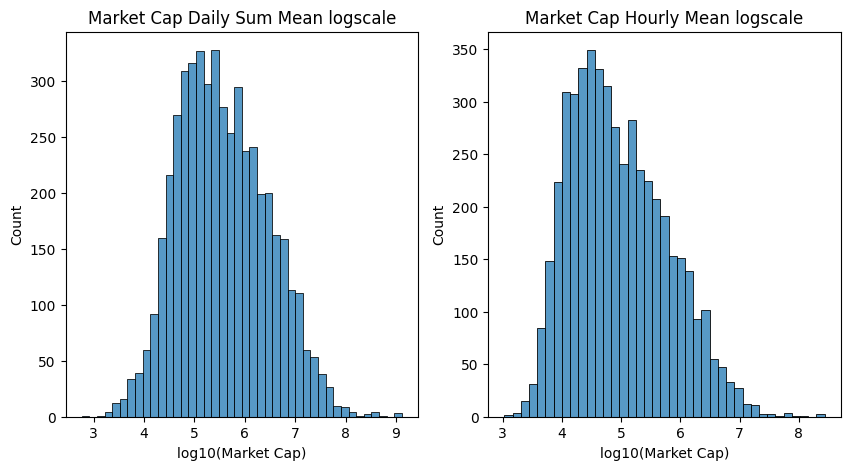

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(np.log10(capDayMean), ax = ax[0])
sns.histplot(np.log10(capHrMean), ax = ax[1])
ax[0].set_title('Market Cap Daily Sum Mean logscale')
ax[1].set_title('Market Cap Hourly Mean logscale')
ax[0].set_xlabel('log10(Market Cap)')
ax[1].set_xlabel('log10(Market Cap)')
plt.show()

Filtering data on basis of:

1.   Number of time points = at least 90% of expected
2.   Average Hourly Marketcap of at least 14K (~100K daily)
3.   Average Daily Marketcap of atleat 100K

In [5]:
posTickers = [ticker for ticker in data if len(data[ticker])>4500 and np.log10(data[ticker].cap.mean())>4.15 and np.log10(data[ticker].cap.resample('D').sum().mean())>5]
print(f'Ratio of Filtered data = {round(len(posTickers)/len(data),3)}')
print(f'Total number of stocks after filtering : {len(posTickers)}')

Ratio of Filtered data = 0.567
Total number of stocks after filtering : 3316


## Generating plots of historical price movement including volume:

*   each image is a period of 90 trading days
*   the target timepoint is 10 days after the image period ends, 10 hours are averaged for the target
*   images are taken at a 5-trading-days stride
*   100 plots of candlesticks and volume are screened for each ticker
*   plots are saved only if at that target is between -5% and 5%
*   previous version had plots saved only if at that target is below -10% and above 10%. these seperated data files will be united in the next script



In [6]:
st = 5 #stride in days
rng = 90 #dataRange in days
prd = 10 #predictionPeriod in days
h4d = 7
targetBuffer = 5 #time periods
# minRelativePriceMove = 0.1
dpi = 64
figsize = (5, 5)
nStrides4Ticker = 100  # 120 are possible in these setting however last 20 chronological figures are not screened
totalNumOfHours = 5000


0   SSSS  :  5000
1   SSYS  :  5000
2   STAA  :  5000
3   STAF  :  5000
4   STBA  :  5000
5   STEP  :  5000
6   STER  :  5000
7   STGW  :  5000
8   STKL  :  5000
9   STLD  :  5000
10   STNE  :  5000
11   STOK  :  5000
12   STRA  :  5000
13   STRL  :  5000
14   STRO  :  5000
15   STX  :  5000
16   SUPN  :  5000
17   SUSB  :  5000
couldnt save image  62  @ SUSB
763   762   762
18   SUSC  :  5000
19   SVC  :  5000
20   SWBI  :  5000
21   SWIM  :  5000
22   SWKS  :  5000
23   SWTX  :  5000
24   SYBT  :  5000
25   SYM  :  5000
26   SYNA  :  5000
27   SYRE  :  5000
28   SYTA  :  5000
29   TALK  :  5000
30   TARS  :  5000
31   TASK  :  5000
32   TBBK  :  5000
33   TBLD  :  4768
34   TBPH  :  5000
35   TCBI  :  5000
36   TCBK  :  5000
37   TCMD  :  5000
38   TCOM  :  5000
39   TCPC  :  5000
40   TCRT  :  5000
41   TDIV  :  5000
42   TDUP  :  5000
43   TEAM  :  5000
44   TECH  :  5000
45   TENB  :  5000
46   TER  :  5000
47   TERN  :  5000
48   TFIN  :  5000
49   TFSL  :  5000
50   TGTX  :  500

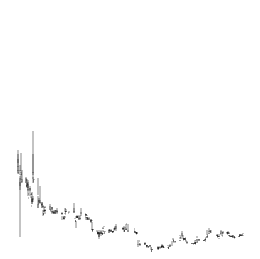

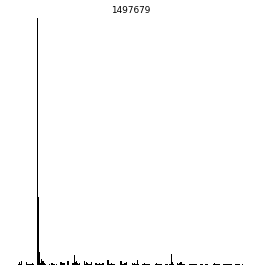

In [7]:
minRelativePriceMove = 0.05
strtIdx = 195
endIdx = 3317 #number of stocks
startStrideAt0 = False #change to False if run was interrupted
startStrideNumber = 26

#generate a copy of the df to be updated ech iteration
scaledDF = deepcopy(data[posTickers[0]])
scaledDF = scaledDF.iloc[:,1:5]

fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)
fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)

stockImgs,capImgs,targets = [],[],[]
start_time = time.time()
for j,ticker in enumerate(posTickers[strtIdx:endIdx]):

  # create the target vector
  labels = (data[ticker].close / data[ticker].close.shift(prd*h4d)).values - 1
  print(j,' ',ticker,' : ',len(labels))

  # Extract the volume data and corresponding dates
  volume_data = data[ticker].cap.values
  volume_dates = data[ticker].index

  #fig, axs = plt.subplots(12,10,figsize=(15,9), dpi=64) #120 for ALL time points, need to remove last ten so as to not to contaminate when testing
  if startStrideAt0==False :
    startStrideAt0 = True
  else :
    startStrideNumber = 0

  for i in range(startStrideNumber,nStrides4Ticker):

    # create the target for the image
    target = np.mean(labels[i*h4d*st+h4d*rng-targetBuffer:i*h4d*st+h4d*rng+targetBuffer]) #stride + dataRange +-1day (=~10 hours)
    if minRelativePriceMove >= target >= -minRelativePriceMove:

      try:
        targets.append(target)
        scaler = MinMaxScaler()

        #for stocks with less than the expected timepoints:
        if len(labels) < 5000:
          padding = np.zeros((5000-len(labels),4))
          data_array = np.vstack((data[ticker].iloc[:,1:5].values, padding))
        else:
          data_array = data[ticker].iloc[:,1:5].values

        scaledDF.iloc[:,:] = scaler.fit_transform(data_array)

        # the first opening value is set to 0.5
        priceFix = 0.5/scaledDF.iloc[i*h4d*st,0]
        scaledDF *= priceFix

        # Plot 1: candlestick chart without volume
        ax1.clear()
        '''fig1, (ax1,ax2) = plt.subplots(1,2,figsize=figsize,dpi=dpi)
        fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)'''
        mpf.plot(scaledDF.iloc[i*h4d*st:h4d*rng+h4d*st*i,:],
                type='ohlc',
                ax=ax1,
                volume=False,
                style='classic',
                show_nontrading=True)

        ax1.axis('off')
        ax1.set_ylim(0.1,1.1)
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        '''ax1.set_title(ticker+' '+str(i)+' '+str(count)+' '+str(round(target,2)))
        plt.show()'''

        # transform into a greyscale array
        fig1.canvas.draw()
        rgba_array = np.frombuffer(fig1.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
        stockImgs.append( (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255)
        '''plt.imshow(grey_array,cmap='gray')
        plt.show()'''

        # Plot 2: Volume Only
        ax2.clear()
        ax2.bar(volume_dates[i*h4d*st:h4d*rng+h4d*st*i], volume_data[i*h4d*st:h4d*rng+h4d*st*i], color='black', width=0.75)
        ax2.set_ylim(0,np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i]))
        ax2.set_title(int(np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i])),fontsize=10)
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        '''plt.show()'''

         # transform into a greyscale array
        fig2.canvas.draw()
        rgba_array = np.frombuffer(fig2.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
        capImgs.append((0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255)

        # save every 1000 candlestick+volume plots
        if len(capImgs)%3000 ==0:
          np.savez_compressed(savePath+'StockImgs_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *stockImgs)
          np.savez_compressed(savePath+'CapImgs_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *capImgs)
          np.savez_compressed(savePath+'Targets_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *targets)
          print(len(capImgs),' images saved, ',j+strtIdx,' ticker number,',i,' stride number, ',time.time()-start_time,' seconds passed')
          stockImgs,capImgs,targets = [],[],[]
      except:
        print('couldnt save image ',i,' @',ticker)
        print(len(targets),' ',len(stockImgs),' ',len(capImgs))
        targets=targets[:-1]
        continue

# final save
np.savez_compressed(savePath+'StockImgs_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *stockImgs)
np.savez_compressed(savePath+'CapImgs_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *capImgs)
np.savez_compressed(savePath+'Targets_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *targets)

print(endIdx-strtIdx,' tickers : ',time.time()-start_time)

In [ ]:
'''# attempt at creating plots as images. had bug.
def plotCandlestick(ax,scaledDF,startPlot,endPlot):
  ax.clear()
  '''fig1, (ax1,ax2) = plt.subplots(1,2,figsize=figsize,dpi=dpi)
  fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)'''
  mpf.plot(scaledDF.iloc[startPlot:endPlot,:],
          type='ohlc',
          ax=ax,
          volume=False,
          style='classic',
          show_nontrading=True)
  ax.axis('off')
  ax.set_ylim(0.1,1.1)
  return(removePlotBorders(ax))

def plotMarketCap(ax,volume_dates,volume_data,startPlot,endPlot):
  # plt.plot(volume_data[startPlot:endPlot])
  ax.clear()
  ax.bar(volume_dates[startPlot:startPlot], volume_data[startPlot:startPlot], color='black', width=0.75)
  # ax.set_ylim(0,np.max(volume_data[startPlot:endPlot]))
  ax.set_title(int(np.max(volume_data[startPlot:endPlot])),fontsize=10)

  # plt.show()
  return(removePlotBorders(ax))

def removePlotBorders(ax):
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  for edge in ['top', 'right', 'bottom', 'left']:
      ax.spines[edge].set_visible(False)
  return(ax)
  '''ax1.set_title(ticker+' '+str(i)+' '+str(count)+' '+str(round(target,2)))
  plt.show()'''

def greyArray(fig):
  # transform into a greyscale array
  fig.canvas.draw()
  rgba_array = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
  '''plt.imshow(grey_array,cmap='gray')
  plt.show()'''
  return (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255



def generatePlots(posTickers,strtIdx,endIdx,saveEvery=4000,startStrideAt0=False,startStrideNumber=0):

  #generate a copy of the df to be updated each iteration
  scaledDF = deepcopy(data[posTickers[0]])
  scaledDF = scaledDF.iloc[:,1:5]

  fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)
  fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)

  stockImgs,capImgs,targets = [],[],[]
  start_time = time.time()
  for j,ticker in enumerate(posTickers[strtIdx:endIdx]):

    # create the target vector
    labels = (data[ticker].close / data[ticker].close.shift(prd*h4d)).values - 1
    print(j,' ',ticker,' : ',len(labels))

    # Extract the volume data and corresponding dates
    volume_data = data[ticker].cap.values
    volume_dates = data[ticker].index

    #fig, axs = plt.subplots(12,10,figsize=(15,9), dpi=64) #120 for ALL time points, need to remove last ten so as to not to contaminate when testing
    if startStrideAt0==False :
      startStrideAt0 = True
    else :
      startStrideNumber = 0

    for i in range(startStrideNumber,nStrides4Ticker):

      # create the target for the image
      target = np.mean(labels[i*h4d*st+h4d*rng-targetBuffer:i*h4d*st+h4d*rng+targetBuffer]) #stride + dataRange +-1day (=~10 hours)


      if target<=minRelativePriceMove and target>=-minRelativePriceMove:

        # try:
        targets.append(target)
        scaler = MinMaxScaler()

        #for stocks with less than the expected timepoints:
        if len(labels) < totalNumOfHours:
          padding = np.zeros((totalNumOfHours-len(labels),4))
          data_array = np.vstack((data[ticker].iloc[:,1:5].values, padding))
        else:
          data_array = data[ticker].iloc[:,1:5].values

        scaledDF.iloc[:,:] = scaler.fit_transform(data_array)

        # the first opening value is set to 0.5
        priceFix = 0.5/scaledDF.iloc[i*h4d*st,0]
        scaledDF *= priceFix

        # Plot 1: candlestick chart without volume
        ax1 = plotCandlestick(ax1,scaledDF,i*h4d*st,h4d*(rng+st*i))
        '''ax1.set_title(ticker+' '+str(i)+' '+str(count)+' '+str(round(target,2)))
        plt.show()'''
        stockImgs.append(greyArray(fig1))


        # Plot 2: Volume Only
        ax2 = plotMarketCap(ax2,volume_dates,volume_data,i*h4d*st,h4d*(rng+st*i))
        '''ax1.set_title(ticker+' '+str(i)+' '+str(count)+' '+str(round(target,2)))'''
        capImgs.append(greyArray(fig2))

        if len(capImgs)%saveEvery ==0:
          for title, datalist in zip(['StockImgs','CapImgs','Targets'],[stockImgs,capImgs,targets]):
            np.savez_compressed(savePath+'StockImgs_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_24Sept2024_targetsBelow5.npz', *datalist)
          print(len(capImgs),' images saved, ',j+strtIdx,' ticker number,',i,' stride number, ',time.time()-start_time,' seconds passed')
          stockImgs,capImgs,targets = [],[],[]
        except:
          print('couldnt save image ',i,' @',ticker)
          print(len(targets),' ',len(stockImgs),' ',len(capImgs))
          targets=targets[:-1]
          continue

  # final save
  for title, datalist in zip(['StockImgs','CapImgs','Targets'],[stockImgs,capImgs,targets]):
      np.savez_compressed(savePath+'StockImgs_asList_'+str(strtIdx)+'-'+str(j+strtIdx)+'_targetsBelow5.npz', *datalist)
  print(len(capImgs),' images saved, ',j+strtIdx,' ticker number,',i,' stride number, ',time.time()-start_time,' seconds passed')
  return (stockImgs,capImgs,targets)'''

In [ ]:
'''
# Extracting the date part from the Timestamps for comparison
date1 = data[posTickers[0]].index[70]
for i in range(10):
  for j in range(8):
    date2 = data[posTickers[0]].index[0] + timedelta(days=(10+i))+timedelta(hours=(0+j))
    if date1 == date2:
# Perform the comparison
      print(i,' ',j)
      day = i
      hour = j
print(date1)
print(data[posTickers[0]].index[0] + timedelta(days=(10+day))+timedelta(hours=(-2+hour)))
'''

In [ ]:
'''
def loadAndCombineData(all_data,savePath,exchange,start_idx,interval,end_idx,day,month,year):
  print(exchange)
  date = str(day)+str(month)+str(year)
  for idx in range(start_idx,end_idx+interval,interval):
    with open(savePath+'TVstockData_'+exchange+'_'+date+'_'+str(idx)+'.pickle', 'rb') as file:
        data = pd.read_pickle(file)
    all_data = {**all_data, **data}
  return(all_data)

savePath ='/content/drive/MyDrive/myStocksSept2024/'

date = str(18)+str(9)+str(2024)
with open(savePath+'TVstockData_NASDAQ_'+date+'_1000.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
print(len(nasdaq_data))
nasdaq_data = loadAndCombineData(nasdaq_data,savePath,'NASDAQ',1000,100,3700,18,9,2024)
print(len(nasdaq_data))
nasdaq_data = loadAndCombineData(nasdaq_data,savePath,'NASDAQ',3800,100,4800,20,9,2024)
print(len(nasdaq_data))
date = str(20)+str(9)+str(2024)
with open(savePath+'TVstockData_NASDAQ_'+date+'_final_4803.pickle', 'rb') as file:
        current_data = pd.read_pickle(file)
nasdaq_data = {**nasdaq_data, **current_data}
print(len(nasdaq_data))

with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'wb') as file:
        pickle.dump(nasdaq_data,file)

nyse_data = loadAndCombineData({},savePath,'NYSE',1000,1000,6000,17,9,2024)
print(len(nyse_data))
date = str(17)+str(9)+str(2024)
with open(savePath+'TVstockData_NYSE_'+date+'_final_6293.pickle', 'rb') as file:
        current_data = pd.read_pickle(file)
nyse_data = {**nyse_data, **current_data}
print(len(nyse_data))

with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'wb') as file:
        pickle.dump(nyse_data,file)

data = { **nasdaq_data,**nyse_data}
print(len(data))
'''